In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



# Predictive Maintenance — Frequency & Duration Deep Learning

**Goal:** Run first experiments on our OBD-II snapshot to compute *exposure* (frequency/duration)
metrics, infer per-vehicle thresholds, build windowed data, and (optionally) train a tiny unsupervised
temporal model (TCN Autoencoder) to produce residual/prediction-error scores. We keep everything
**subsystem-specific** (cooling, load/air-flow, ignition, electrical, powertrain proxy).


## 0) Setups

### 0.1) Configs

In [100]:
# Cell 1 — Imports & global setup
import os
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd

# Matplotlib (charts: one plot per figure; no styles/colors specified)
import matplotlib.pyplot as plt

# Reproducibility
np.random.seed(42)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

In [101]:
# Cell 2 — Configuration

from pathlib import Path

# Primary path on Colab (Google Drive mounted)
DRIVE_PATH = Path("/content/drive/My Drive/EAT40005/Logs/test1.csv")

# Local fallback sample (if DRIVE_PATH not present)
LOCAL_FALLBACK = Path("/mnt/data/test1_sample.csv")

# Windowing (seconds)
WINDOW_SEC = 60.0      # typical 60–120 on full logs
STRIDE_SEC = 10.0      # typical 10–20 on full logs

# Subsystem PID maps (present-only columns will be used)
SUBSYSTEMS = {
    "cooling": ["COOLANT_TEMP", "INTAKE_TEMP", "OIL_TEMP", "ENGINE_LOAD"],
    "load_air": ["ENGINE_LOAD", "ABSOLUTE_LOAD", "AIRFLOW_PER_RPM", "INTAKE_PRESSURE", "SHORT_FUEL_TRIM_1"],
    "ignition": ["TIMING_ADVANCE", "RPM", "ENGINE_LOAD"],
    "electrical": ["CONTROL_MODULE_VOLTAGE"],
    "powertrain_proxy": ["RPM", "SPEED", "THROTTLE_POS"],
}

# Scoring weights (tune per subsystem)
WEIGHTS = dict(TOT=1.0, FREQ=0.6, MAXRUN=0.8, AE=0.7, FC=0.6, CONC=0.9)

# Hysteresis config (k of n) for alerts
ALERT_K = 3
ALERT_N = 6

# High-stress thresholds (for per-sensor exposure masks)
Q_HIGH = 0.85

# Safety offsets
THRESH_MARGIN = 0.95   # multiply threshold by 0.95 to drop it 5%

# --- New calibration knobs for alert thresholding (per-subsystem) ---
# We combine a trimmed quantile threshold with a robust MAD cap and take the MIN of the two.
THRESH_Q   = 0.85   # quantile over the (trimmed) score distribution
MAD_MULT   = 1.5    # threshold cap = median + MAD_MULT * 1.4826 * MAD
TRIM_TOP   = 0.05   # trim away top 10% scores before computing quantile/MAD (prevents inflated thresholds)
MIN_THRESH = None   # optional absolute floor (e.g., 50.0); keep None unless needed
MAX_THRESH = None   # optional absolute cap  (e.g., 400.0); keep None unless needed


### 0.2) Data loader

In [102]:
# Cell 3.0 — Data loading & normalization helpers

def read_any(path: Path) -> pd.DataFrame:
    """Robust CSV/TSV reader (auto-detect delimiter when possible)."""
    if not path.exists():
        raise FileNotFoundError(f"Missing file: {path}")
    try:
        return pd.read_csv(path, sep=None, engine="python")
    except Exception:
        # fallback to comma
        try:
            return pd.read_csv(path)
        except Exception:
            # fallback to tab
            return pd.read_csv(path, sep="\t")

def load_dataframe(drive_path: Path, fallback_path: Path) -> pd.DataFrame:
    try:
        df_ = read_any(drive_path)
        print(f"Loaded from Drive: {drive_path}")
    except Exception as e:
        print(f"Drive path not readable ({e}); using fallback: {fallback_path}")
        df_ = read_any(fallback_path)

    # Timestamp handling
    df_["timestamp"] = pd.to_datetime(df_["timestamp"], errors="coerce", utc=True)
    df_ = df_.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)

    # Attempt numeric coercion where appropriate
    for c in df_.columns:
        if c == "timestamp":
            continue
        try:
            df_[c] = pd.to_numeric(df_[c], errors="ignore")
        except Exception:
            pass
    return df_

df = load_dataframe(DRIVE_PATH, LOCAL_FALLBACK)
display(df.head())
print(df.shape)
print(df.columns.tolist())

Loaded from Drive: /content/drive/My Drive/EAT40005/Logs/test1.csv


/tmp/ipython-input-798205299.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_[c] = pd.to_numeric(df_[c], errors="ignore")


,timestamp,driving_style,road_type,RPM,THROTTLE_POS,SPEED,ENGINE_LOAD,COOLANT_TEMP,INTAKE_TEMP,TIMING_ADVANCE,MAF,INTAKE_PRESSURE,SHORT_FUEL_TRIM_1,LONG_FUEL_TRIM_1,SHORT_FUEL_TRIM_2,LONG_FUEL_TRIM_2,O2_B1S2,O2_B2S2,O2_S1_WR_VOLTAGE,AIRFLOW_PER_RPM
0,2025-05-14 18:51:47.119307+00:00,UNKNOWN_STYLE,UNKNOWN_ROAD,0.037193,0.018182,0.0,0.0,0.0,1.0,0.38806,0.0,0.065789,0.833333,1.0,0.866667,0.4,0.48503,0.158273,0.02418,0.119962
1,2025-05-14 18:51:47.629307+00:00,UNKNOWN_STYLE,UNKNOWN_ROAD,0.035437,0.018182,0.0,0.0,0.0,1.0,0.38806,0.0,0.065789,0.833333,1.0,0.866667,0.4,0.48503,0.158273,0.02418,0.121429
2,2025-05-14 18:51:48.139307+00:00,UNKNOWN_STYLE,UNKNOWN_ROAD,0.035437,0.018182,0.0,0.0,0.0,1.0,0.38806,0.0,0.065789,0.833333,1.0,0.866667,0.4,0.48503,0.158273,0.02418,0.121429
3,2025-05-14 18:51:48.649307+00:00,UNKNOWN_STYLE,UNKNOWN_ROAD,0.035437,0.018182,0.0,0.0,0.0,1.0,0.38806,0.0,0.065789,0.833333,1.0,0.866667,0.4,0.48503,0.158273,0.02418,0.121429
4,2025-05-14 18:51:49.159307+00:00,UNKNOWN_STYLE,UNKNOWN_ROAD,0.035437,0.018182,0.0,0.0,0.0,1.0,0.38806,0.0,0.065789,0.833333,1.0,0.866667,0.4,0.48503,0.158273,0.02418,0.121429


(3298, 20)
['timestamp', 'driving_style', 'road_type', 'RPM', 'THROTTLE_POS', 'SPEED', 'ENGINE_LOAD', 'COOLANT_TEMP', 'INTAKE_TEMP', 'TIMING_ADVANCE', 'MAF', 'INTAKE_PRESSURE', 'SHORT_FUEL_TRIM_1', 'LONG_FUEL_TRIM_1', 'SHORT_FUEL_TRIM_2', 'LONG_FUEL_TRIM_2', 'O2_B1S2', 'O2_B2S2', 'O2_S1_WR_VOLTAGE', 'AIRFLOW_PER_RPM']


In [103]:
# Cell 3.1 - Augmentation with Forced High-Stress Episodes

USE_AUGMENTED_DATA = True
EPISODES_PER_SUBSYS = 2     # how many episodes to create
EPISODE_LEN_SEC = (60, 180) # min/max seconds per episode

def force_high_episode(df, col, s, e, factor=1.3):
    """Force a channel into sustained extreme range beyond q99."""
    if col not in df: return
    vals = df[col].dropna().astype(float)
    if vals.empty: return
    q99 = np.nanquantile(vals, 0.99)
    hi = min(1.0, q99 * factor)
    df.loc[s:e, col] = hi

def inject_strong_stress(df, subsystem, dt, rng):
    n = len(df)
    L = int(rng.integers(
        int(EPISODE_LEN_SEC[0] / dt),
        int(EPISODE_LEN_SEC[1] / dt)
    ))
    s = rng.integers(0, max(1, n-L))
    e = min(n-1, s+L)

    if subsystem == "cooling":
        for c in ["COOLANT_TEMP","INTAKE_TEMP","ENGINE_LOAD"]:
            force_high_episode(df, c, s, e, factor=1.5)

    elif subsystem == "load_air":
        for c in ["ENGINE_LOAD","AIRFLOW_PER_RPM","INTAKE_PRESSURE"]:
            force_high_episode(df, c, s, e, factor=1.4)

    elif subsystem == "ignition":
        if "TIMING_ADVANCE" in df:
            # oscillate advance
            vals = np.linspace(-1, 1, e-s+1)
            df.loc[s:e, "TIMING_ADVANCE"] = vals
        force_high_episode(df, "RPM", s, e, factor=1.5)

    elif subsystem == "powertrain":
        force_high_episode(df, "RPM", s, e, factor=1.6)
        if "SPEED" in df:
            df.loc[s:e, "SPEED"] = 0.01  # suppressed speed

    df.loc[s:e,"augmented_flag"] = True
    df.loc[s:e,"augmented_subsystem"] = subsystem

# --- Apply augmentation ---
df_aug = df.copy()
df_aug["augmented_flag"] = False
df_aug["augmented_subsystem"] = ""

rng = np.random.default_rng(42)
dt = np.median(df["timestamp"].sort_values().diff().dropna().dt.total_seconds())
for subsys in ["cooling","load_air","ignition","powertrain"]:
    for _ in range(EPISODES_PER_SUBSYS):
        inject_strong_stress(df_aug, subsys, dt, rng)

if USE_AUGMENTED_DATA:
    df = df_aug

print("Augmentation applied. Subsystems stressed:", df["augmented_subsystem"].value_counts())

Augmentation applied. Subsystems stressed: augmented_subsystem
              1954
ignition       410
powertrain     368
load_air       292
cooling        274
Name: count, dtype: int64


                           timestamp  augmented_flag augmented_subsystem
295 2025-05-14 18:54:17.492621+00:00            True            ignition
296 2025-05-14 18:54:17.997719+00:00            True            ignition
297 2025-05-14 18:54:18.502806+00:00            True            ignition
298 2025-05-14 18:54:19.007904+00:00            True            ignition
299 2025-05-14 18:54:19.512965+00:00            True            ignition
300 2025-05-14 18:54:20.017856+00:00            True            ignition
301 2025-05-14 18:54:20.523076+00:00            True            ignition
302 2025-05-14 18:54:21.023324+00:00            True            ignition
303 2025-05-14 18:54:21.528368+00:00            True            ignition
304 2025-05-14 18:54:22.030470+00:00            True            ignition


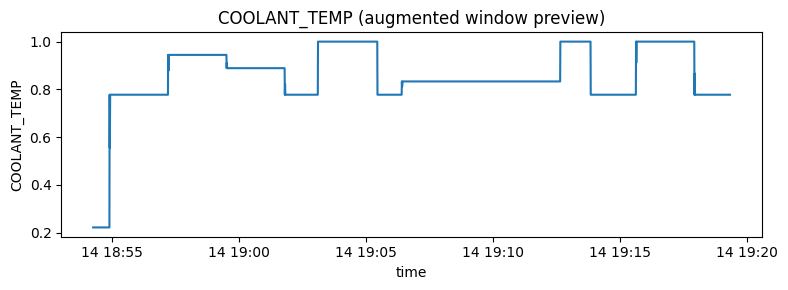

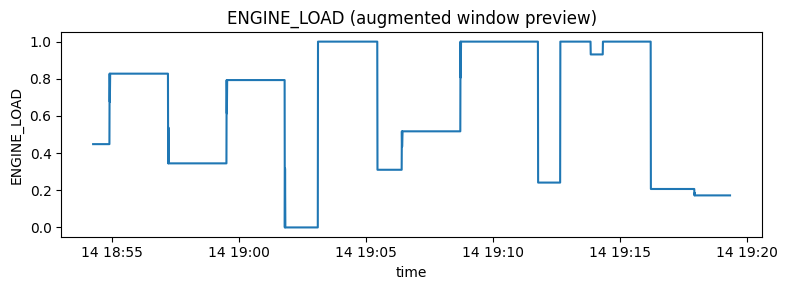

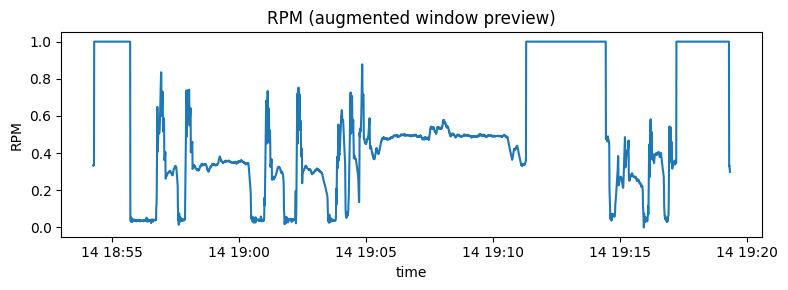

In [104]:
# Cell 3.2 — Optional: Sanity checks for augmentation (non-destructive visual & stats)

def preview_augmented_segments(frame: pd.DataFrame, cols: List[str], max_plots: int = 3):
    aidx = np.flatnonzero(frame["augmented_flag"].to_numpy()) if "augmented_flag" in frame.columns else np.array([])
    if aidx.size == 0:
        print("No augmented rows to preview.")
        return
    s = int(aidx.min())
    e = int(aidx.max()) + 1
    subset = frame.iloc[max(0, s - 5):min(len(frame), e + 5)].copy()
    shown = 0
    for c in cols:
        if c not in subset.columns:
            continue
        plt.figure(figsize=(8, 3))
        plt.plot(subset["timestamp"], subset[c])
        plt.title(f"{c} (augmented window preview)")
        plt.xlabel("time")
        plt.ylabel(c)
        plt.tight_layout()
        plt.show()
        shown += 1
        if shown >= max_plots:
            break

if "augmented_flag" in df.columns and df["augmented_flag"].any():
    print(df[["timestamp","augmented_flag","augmented_subsystem"]].query("augmented_flag").head(10))
    # Preview a few key channels if present
    preview_cols = [c for c in ["COOLANT_TEMP","ENGINE_LOAD","RPM","SPEED","AIRFLOW_PER_RPM","TIMING_ADVANCE"] if c in df.columns]
    preview_augmented_segments(df, preview_cols, max_plots=3)
else:
    print("Augmentation toggled off or no episodes planned (dataset too short).")

## 1) Quick profile

In [105]:
# Cell 4 — Quick profile (types, basic stats, missingness)

display(df.dtypes)
display(df.describe(include="all").T.head(30))

missing = df.isna().mean().sort_values(ascending=False)
print("Top missing columns:")
display(missing.head(15))

,0
timestamp,"datetime64[ns, UTC]"
driving_style,object
road_type,object
RPM,float64
THROTTLE_POS,float64
SPEED,float64
ENGINE_LOAD,float64
COOLANT_TEMP,float64
INTAKE_TEMP,float64
TIMING_ADVANCE,float64


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
timestamp,3298,NaN,NaN,NaN,2025-05-14 19:05:50.738115328+00:00,2025-05-14 18:51:47.119307+00:00,2025-05-14 18:58:49.253969664+00:00,2025-05-14 19:05:50.998378496+00:00,2025-05-14 19:12:52.962317568+00:00,2025-05-14 19:19:54.523038+00:00,NaN
driving_style,3298,2,mild,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN
road_type,3298,6,road main,1403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RPM,3298.0,NaN,NaN,NaN,0.488872,0.0,0.288086,0.439193,0.673733,1.0,0.325895
THROTTLE_POS,3298.0,NaN,NaN,NaN,0.138379,0.0,0.054545,0.109091,0.181818,1.0,0.124357
SPEED,3298.0,NaN,NaN,NaN,0.441377,0.0,0.076446,0.454545,0.68595,1.0,0.321339
ENGINE_LOAD,3298.0,NaN,NaN,NaN,0.599647,0.0,0.310345,0.517241,1.0,1.0,0.348644
COOLANT_TEMP,3298.0,NaN,NaN,NaN,0.790405,0.0,0.777778,0.833333,0.944444,1.0,0.238807
INTAKE_TEMP,3298.0,NaN,NaN,NaN,0.277544,0.0,0.043478,0.086957,0.26087,1.0,0.363841
TIMING_ADVANCE,3298.0,NaN,NaN,NaN,0.579589,-1.0,0.373134,0.791045,0.865672,1.0,0.410336


Top missing columns:


,0
timestamp,0.0
driving_style,0.0
road_type,0.0
RPM,0.0
THROTTLE_POS,0.0
SPEED,0.0
ENGINE_LOAD,0.0
COOLANT_TEMP,0.0
INTAKE_TEMP,0.0
TIMING_ADVANCE,0.0


## 2) Infer base sampling interval (seconds)

In [106]:
# Cell 5 — Base sampling interval inference

def infer_base_interval_seconds(ts: pd.Series) -> float:
    ts = ts.sort_values()
    diffs = ts.diff().dropna().dt.total_seconds()
    diffs = diffs[diffs > 0]
    if diffs.empty:
        return 1.0
    q05, q95 = diffs.quantile([0.05, 0.95])
    core = diffs[(diffs >= q05) & (diffs <= q95)]
    if core.empty:
        core = diffs
    rounded = (core / 0.01).round() * 0.01
    mode = rounded.mode()
    return float(mode.iloc[0] if not mode.empty else core.median())

BASE_SEC = infer_base_interval_seconds(df["timestamp"])
DT = BASE_SEC if BASE_SEC > 0 else 1.0
print(f"Inferred base interval ≈ {BASE_SEC:.3f} s (dt={DT})")

Inferred base interval ≈ 0.510 s (dt=0.51)


## 3) Exposure metrics — TOT, Frequency, Max run, Concurrency

In [107]:
# Cell 6 — Exposure metrics (TOT, burst frequency, max-run) & thresholds

def per_vehicle_thresholds(frame: pd.DataFrame, cols: List[str], q_high: float = 0.95) -> Dict[str, float]:
    thr = {}
    for c in cols:
        if c in frame.columns and pd.api.types.is_numeric_dtype(frame[c]):
            s = frame[c].dropna().astype(float)
            if len(s) >= 5:
                thr[c] = float(s.quantile(q_high))
    return thr

def exposure_from_mask(mask: np.ndarray, dt: float) -> Tuple[float, int, float]:
    """Return TOT (seconds), episode frequency (0->1), max run length (seconds)."""
    if mask.size == 0:
        return 0.0, 0, 0.0

    tot = float(mask.sum() * dt)
    eps = int(((~mask[:-1]) & mask[1:]).sum()) if len(mask) > 1 else int(mask.sum() > 0)

    max_run = 0.0
    if mask.any():
        lengths = []
        cnt = 0
        for m in mask:
            if m:
                cnt += 1
            else:
                if cnt:
                    lengths.append(cnt)
                cnt = 0
        if cnt:
            lengths.append(cnt)
        if lengths:
            max_run = float(max(lengths) * dt)
    return tot, eps, max_run

def compute_exposure_bundle(frame: pd.DataFrame, cols: List[str], dt: float, q_high: float = 0.95) -> Dict[str, Dict[str, float]]:
    """Per-sensor exposure stats + thresholds."""
    present = [c for c in cols if c in frame.columns and pd.api.types.is_numeric_dtype(frame[c])]
    th = per_vehicle_thresholds(frame, present, q_high=q_high)
    out: Dict[str, Dict[str, float]] = {}
    for c in present:
        x = frame[c].to_numpy(dtype=float)
        thr = th.get(c, np.nan)
        if np.isnan(thr):
            continue
        mask = x >= thr
        tot, eps, mrun = exposure_from_mask(mask, dt)
        out[c] = dict(TOT=tot, FREQ=eps, MAXRUN=mrun, THRESHOLD=thr)
    return out

def concurrency_mask(frame: pd.DataFrame, cols: List[str], thresholds: Dict[str, float]) -> np.ndarray:
    """Logical AND across thresholded channels."""
    if not cols:
        return np.zeros(len(frame), dtype=bool)
    mask = np.ones(len(frame), dtype=bool)
    for c in cols:
        if c not in frame.columns or c not in thresholds:
            return np.zeros(len(frame), dtype=bool)
        mask &= (frame[c].to_numpy(dtype=float) >= thresholds[c])
    return mask


## 4) Exposure per subsystem

In [108]:
# Cell 7 — Compute exposure per subsystem (full-log level summary)

exposure_by_subsystem: Dict[str, Dict[str, Dict[str, float]]] = {}
for name, cols in SUBSYSTEMS.items():
    present = [c for c in cols if c in df.columns]
    exposure_by_subsystem[name] = compute_exposure_bundle(df, present, DT, q_high=Q_HIGH)

# Show summary
for name, exp in exposure_by_subsystem.items():
    print(f"\nSubsystem: {name}")
    if not exp:
        print("  (no numeric PIDs present)")
        continue
    for pid, stats in exp.items():
        print(f"  {pid}: TOT={stats['TOT']:.3f}s  FREQ={stats['FREQ']}  MAXRUN={stats['MAXRUN']:.3f}s  THR~{stats['THRESHOLD']:.5f}")


Subsystem: cooling
  COOLANT_TEMP: TOT=347.310s  FREQ=4  MAXRUN=139.740s  THR~1.00000
  INTAKE_TEMP: TOT=260.610s  FREQ=2  MAXRUN=139.740s  THR~1.00000
  ENGINE_LOAD: TOT=505.920s  FREQ=5  MAXRUN=181.050s  THR~1.00000

Subsystem: load_air
  ENGINE_LOAD: TOT=505.920s  FREQ=5  MAXRUN=181.050s  THR~1.00000
  AIRFLOW_PER_RPM: TOT=252.450s  FREQ=31  MAXRUN=115.770s  THR~0.54966
  INTAKE_PRESSURE: TOT=320.790s  FREQ=4  MAXRUN=136.170s  THR~1.00000
  SHORT_FUEL_TRIM_1: TOT=348.330s  FREQ=6  MAXRUN=137.700s  THR~0.94444

Subsystem: ignition
  TIMING_ADVANCE: TOT=275.910s  FREQ=4  MAXRUN=273.360s  THR~0.98507
  RPM: TOT=397.290s  FREQ=4  MAXRUN=187.680s  THR~1.00000
  ENGINE_LOAD: TOT=505.920s  FREQ=5  MAXRUN=181.050s  THR~1.00000

Subsystem: electrical
  (no numeric PIDs present)

Subsystem: powertrain_proxy
  RPM: TOT=397.290s  FREQ=4  MAXRUN=187.680s  THR~1.00000
  SPEED: TOT=268.770s  FREQ=7  MAXRUN=184.110s  THR~0.86777
  THROTTLE_POS: TOT=254.490s  FREQ=100  MAXRUN=37.740s  THR~0.22727


In [109]:
# Cell 8 — Concurrency

def subsystem_concurrency(frame: pd.DataFrame, subsystem: str, pick: Optional[List[str]] = None):
    cols = SUBSYSTEMS.get(subsystem, [])
    if pick is not None:
        cols = [c for c in pick if c in cols]
    exp = exposure_by_subsystem.get(subsystem, {})
    if not exp:
        return dict(TOT=0.0, FREQ=0, MAXRUN=0.0, cols=[])
    thr = {k: v["THRESHOLD"] for k, v in exp.items()}
    # Heuristic: pick two representative channels if not specified
    if pick is None:
        ordered = list(exp.keys())
        chosen = [x for x in ["ENGINE_LOAD", "COOLANT_TEMP", "RPM"] if x in ordered]
        if len(chosen) < 2:
            # fallback: first two
            chosen = ordered[:2]
    else:
        chosen = [c for c in pick if c in exp]
    mask = concurrency_mask(frame, chosen, thr)
    tot, freq, maxrun = exposure_from_mask(mask, DT)
    return dict(TOT=tot, FREQ=freq, MAXRUN=maxrun, cols=chosen)

print(subsystem_concurrency(df, "cooling", pick=["ENGINE_LOAD", "COOLANT_TEMP"]))
print(subsystem_concurrency(df, "load_air"))


{'TOT': 245.82, 'FREQ': 4, 'MAXRUN': 139.74, 'cols': ['ENGINE_LOAD', 'COOLANT_TEMP']}
{'TOT': 190.74, 'FREQ': 3, 'MAXRUN': 113.22, 'cols': ['ENGINE_LOAD', 'AIRFLOW_PER_RPM']}


## 5) Window rolling

In [110]:
# Cell 9 — Windowing by time (for rolling risk and deep models)

def make_windows(frame: pd.DataFrame, window_sec: float, stride_sec: float) -> List[pd.DataFrame]:
    ts = frame["timestamp"].to_numpy()
    if len(ts) < 2:
        return []
    start = ts[0]
    windows: List[pd.DataFrame] = []
    i = 0
    while True:
        t0 = start + np.timedelta64(int(i * stride_sec * 1000), "ms")
        t1 = t0 + np.timedelta64(int(window_sec * 1000), "ms")
        if t1 > ts[-1]:
            break
        chunk = frame[(frame["timestamp"] >= t0) & (frame["timestamp"] < t1)]
        if len(chunk) > 1:
            windows.append(chunk.reset_index(drop=True))
        i += 1
        if i > 200000:  # safety cap
            break
    return windows

windows = make_windows(df, WINDOW_SEC, STRIDE_SEC)
print(f"Windows created: {len(windows)}")


Windows created: 163


In [111]:
# Cell 10 — Per-window exposure + simple risk fusion for a subsystem

def robust_sum(values: List[float]) -> float:
    return float(np.nansum(np.asarray(values, dtype=float))) if values else 0.0

def fuse_exposure(exposure_dict: Dict[str, Dict[str, float]], weights: Dict[str, float]) -> Dict[str, float]:
    """Aggregate per-sensor exposure to a subsystem summary (no deep residuals here)."""
    if not exposure_dict:
        return dict(TOT=0.0, FREQ=0.0, MAXRUN=0.0, AE=0.0, FC=0.0, CONC=0.0, SCORE=0.0)
    TOT = robust_sum([d["TOT"] for d in exposure_dict.values()])
    FREQ = robust_sum([d["FREQ"] for d in exposure_dict.values()])
    MAXRUN = float(max((d["MAXRUN"] for d in exposure_dict.values()), default=0.0))
    AE = 0.0  # to be filled by deep residuals (if available)
    FC = 0.0  # forecaster error (optional)
    CONC = 0.0  # concurrency (set below if needed)
    score = (weights["TOT"] * TOT + weights["FREQ"] * FREQ + weights["MAXRUN"] * MAXRUN
             + weights["AE"] * AE + weights["FC"] * FC + weights["CONC"] * CONC)
    return dict(TOT=TOT, FREQ=FREQ, MAXRUN=MAXRUN, AE=AE, FC=FC, CONC=CONC, SCORE=score)

def per_window_risk(frame: pd.DataFrame, subsystem: str, window_sec: float, stride_sec: float,
                    q_high: float, weights: Dict[str, float], use_concurrency: bool = True) -> pd.DataFrame:
    """Return a DataFrame of rolling risk per window for a given subsystem."""
    ws = make_windows(frame, window_sec, stride_sec)
    rows = []
    cols = SUBSYSTEMS.get(subsystem, [])
    for w in ws:
        exp = compute_exposure_bundle(w, [c for c in cols if c in w.columns], DT, q_high=q_high)
        fused = fuse_exposure(exp, weights)
        # Optionally add concurrency of two representative channels
        if use_concurrency and exp:
            thr = {k: v["THRESHOLD"] for k, v in exp.items()}
            chosen = [x for x in ["ENGINE_LOAD", "COOLANT_TEMP"] if x in exp]
            if len(chosen) >= 2:
                cmask = concurrency_mask(w, chosen[:2], thr)
                c_tot, c_freq, c_max = exposure_from_mask(cmask, DT)
                fused["CONC"] = c_tot
                fused["SCORE"] += weights["CONC"] * c_tot
        rows.append({
            "t0": w["timestamp"].iloc[0],
            "t1": w["timestamp"].iloc[-1],
            **fused
        })
    return pd.DataFrame(rows)

# Example (will likely be empty on very short samples)
risk_cooling_timeline = per_window_risk(df, "cooling", WINDOW_SEC, STRIDE_SEC, Q_HIGH, WEIGHTS)
risk_cooling_timeline.head()

,t0,t1,TOT,FREQ,MAXRUN,AE,FC,CONC,SCORE
0,2025-05-14 18:51:47.119307+00:00,2025-05-14 18:52:46.699445+00:00,69.87,4.0,49.47,0.0,0.0,10.20,121.026
1,2025-05-14 18:51:57.623754+00:00,2025-05-14 18:52:56.813078+00:00,79.56,4.0,38.76,0.0,0.0,20.40,131.328
2,2025-05-14 18:52:07.257004+00:00,2025-05-14 18:53:06.903928+00:00,90.27,4.0,30.09,0.0,0.0,30.60,144.282
3,2025-05-14 18:52:17.544552+00:00,2025-05-14 18:53:17.014679+00:00,100.47,4.0,40.29,0.0,0.0,40.80,171.822
4,2025-05-14 18:52:27.119612+00:00,2025-05-14 18:53:26.812791+00:00,110.16,4.0,49.98,0.0,0.0,50.49,197.985


## 6)  TCN Autoencoder

In [112]:
# Cell 11 — Tiny TCN Autoencoder (torch available); inject residuals to risk

HAS_TORCH = False
try:
    import torch
    import torch.nn as nn
    HAS_TORCH = True
except Exception as e:
    print("PyTorch not available; skipping deep model training.", e)

def build_tensor_windows(windows: List[pd.DataFrame], cols: List[str]):
    """Stack windows into (N, C, T) tensors for conv1d; returns (X, valid_cols)."""
    if not windows:
        return np.zeros((0, 0, 0)), []
    valid_cols = [c for c in cols if c in windows[0].columns and pd.api.types.is_numeric_dtype(windows[0][c])]
    if not valid_cols:
      return np.zeros((0, 0, 0)), []

    # Find the maximum window length
    max_len = max(len(w) for w in windows)

    Xs = []
    for w in windows:
        arr = w[valid_cols].to_numpy(dtype=float).T  # (C, T)
        # Pad shorter windows
        if arr.shape[1] < max_len:
            padding = np.full((arr.shape[0], max_len - arr.shape[1]), np.nan) # Pad with NaN
            arr = np.concatenate([arr, padding], axis=1)
        Xs.append(arr)

    X = np.stack(Xs) if Xs else np.zeros((0, len(valid_cols), 1))
    return X, valid_cols

class TinyTCNAE(nn.Module):
    def __init__(self, c: int):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv1d(c, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.dec = nn.Sequential(
            nn.Conv1d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, c, kernel_size=3, padding=1),
        )
    def forward(self, x):
        z = self.enc(x)
        y = self.dec(z)
        return y

def deep_residuals_for_subsystem(frame: pd.DataFrame, subsystem: str, window_sec: float, stride_sec: float) -> np.ndarray:
    """Return per-window AE residuals (mean absolute error) if torch is available; else empty array."""
    if not HAS_TORCH:
        return np.array([])
    ws = make_windows(frame, window_sec, stride_sec)
    if len(ws) < 3:
        return np.array([])
    cols = [c for c in SUBSYSTEMS.get(subsystem, []) if c in frame.columns]
    X, valid_cols = build_tensor_windows(ws, cols)
    if X.size == 0 or X.shape[0] < 2:
        return np.array([])

    # Handle NaNs by replacing them with a suitable value (e.g., 0 or mean)
    # For simplicity, replacing with 0. Consider a more sophisticated imputation if needed.
    X[np.isnan(X)] = 0.0

    X_t = torch.tensor(X, dtype=torch.float32)  # (N, C, T)
    model = TinyTCNAE(c=X_t.shape[1])
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.L1Loss()

    # Small demo fit; increase epochs on full logs
    epochs = 1
    for _ in range(epochs):
        model.train()
        opt.zero_grad()
        out = model(X_t)
        loss = loss_fn(out, X_t)
        loss.backward()
        opt.step()

    model.eval()
    with torch.no_grad():
        recon = model(X_t)
        resid = torch.mean(torch.abs(recon - X_t), dim=(1, 2)).cpu().numpy()
    return resid

# Compute AE residuals for cooling subsystem
resid = deep_residuals_for_subsystem(
    frame=df,
    subsystem="cooling",
    window_sec=WINDOW_SEC,
    stride_sec=STRIDE_SEC
)

# Inject AE residuals to timeline for "cooling"
if HAS_TORCH and resid.size > 0 and not risk_cooling_timeline.empty:
    # Ensure the number of residuals matches the number of windows
    num_residuals = min(len(resid), len(risk_cooling_timeline))
    r = risk_cooling_timeline.copy().iloc[:num_residuals]
    r["AE"] = resid[:num_residuals]
    r["SCORE"] = (r["SCORE"] + WEIGHTS["AE"] * r["AE"])
    risk_cooling_timeline = r
    display(risk_cooling_timeline.head())
else:
    print("Skipped injecting deep residuals (no torch or not enough windows/residuals).")

,t0,t1,TOT,FREQ,MAXRUN,AE,FC,CONC,SCORE
0,2025-05-14 18:51:47.119307+00:00,2025-05-14 18:52:46.699445+00:00,69.87,4.0,49.47,0.369973,0.0,10.20,121.284981
1,2025-05-14 18:51:57.623754+00:00,2025-05-14 18:52:56.813078+00:00,79.56,4.0,38.76,0.352284,0.0,20.40,131.574599
2,2025-05-14 18:52:07.257004+00:00,2025-05-14 18:53:06.903928+00:00,90.27,4.0,30.09,0.338169,0.0,30.60,144.518718
3,2025-05-14 18:52:17.544552+00:00,2025-05-14 18:53:17.014679+00:00,100.47,4.0,40.29,0.322267,0.0,40.80,172.047587
4,2025-05-14 18:52:27.119612+00:00,2025-05-14 18:53:26.812791+00:00,110.16,4.0,49.98,0.307161,0.0,50.49,198.200012


## 7) Visual checks

In [113]:
# Cell 12 — Hysteresis-based alerts
# Calibrate per-subsystem threshold from its own score series:
# threshold = min( trimmed-quantile(THRESH_Q), median + MAD_MULT * 1.4826 * MAD )
# This fixes over-inflated thresholds that previously suppressed all alerts.

import numpy as np
import pandas as pd

def _trim_top(scores: np.ndarray, trim_top: float) -> np.ndarray:
    s = scores[~np.isnan(scores)]
    if s.size == 0:
        return s
    if trim_top <= 0:
        return s
    cut = np.nanpercentile(s, 100.0 * (1.0 - trim_top))
    return s[s <= cut]

def calibrate_threshold(scores: np.ndarray,
                        q: float = 0.90,
                        mad_mult: float = 2.0,
                        trim_top: float = 0.10,
                        min_thresh: float | None = None,
                        max_thresh: float | None = None) -> float:
    s = scores.astype(float)
    s = s[~np.isnan(s)]
    if s.size == 0:
        return float("nan")
    base = _trim_top(s, trim_top) if trim_top > 0 else s

    # Quantile-based threshold on trimmed base
    t_q = float(np.nanquantile(base, q)) if base.size > 1 else float(base.max())

    # Robust MAD cap on trimmed base
    med = float(np.nanmedian(base))
    mad = float(np.nanmedian(np.abs(base - med))) + 1e-9
    t_mad = med + MAD_MULT * 1.4826 * mad

    thr = min(t_q, t_mad)
    if min_thresh is not None:
        thr = max(thr, float(min_thresh))
    if max_thresh is not None:
        thr = min(thr, float(max_thresh))
    return float(thr)

def hysteresis_alerts(risk_df: pd.DataFrame,
                      score_col: str = "SCORE",
                      k: int = 4, n: int = 6,
                      q: float = THRESH_Q, mad_mult: float = MAD_MULT,
                      trim_top: float = TRIM_TOP,
                      min_thresh: float | None = MIN_THRESH,
                      max_thresh: float | None = MAX_THRESH) -> pd.DataFrame:
    """Mark alert=1 if k of last n windows exceed calibrated threshold."""
    if risk_df.empty or score_col not in risk_df:
        return risk_df
    r = risk_df.copy()
    s = r[score_col].astype(float).to_numpy()

    # Compute alerts from hysteresis threshold
    thr = calibrate_threshold(s, q=q, mad_mult=mad_mult, trim_top=trim_top,
                              min_thresh=min_thresh, max_thresh=max_thresh)

    # Apply margin (drop 5%)
    thr = thr * THRESH_MARGIN

    above = (s >= thr).astype(int)
    alerts = np.zeros_like(above)
    for i in range(len(above)):
        j0 = max(0, i - n + 1)
        if above[j0:i+1].sum() >= k:
            alerts[i] = 1

    r["threshold"] = thr
    r["alert"] = alerts
    # Quick debug line to see calibration stats
    try:
        ratio = float(above.mean())
    except Exception:
        ratio = 0.0
    print(f"[calibration] thr={thr:.3f}  >thr ratio={ratio:.3f}  k={k}/n={n}")
    return r

# Recompute alerts for the cooling subsystem timeline (repeat per subsystem as needed)
risk_cooling_alerts = hysteresis_alerts(
    risk_cooling_timeline,
    score_col="SCORE",
    k=ALERT_K, n=ALERT_N,
    q=THRESH_Q, mad_mult=MAD_MULT, trim_top=TRIM_TOP,
    min_thresh=MIN_THRESH, max_thresh=MAX_THRESH
)

# Peek
display(risk_cooling_alerts.tail(10))
print("Cooling alerts triggered:", int(risk_cooling_alerts["alert"].sum()) if not risk_cooling_alerts.empty else 0)


[calibration] thr=266.777  >thr ratio=0.528  k=3/n=6


,t0,t1,TOT,FREQ,MAXRUN,AE,FC,CONC,SCORE,threshold,alert
153,2025-05-14 19:17:17.455464+00:00,2025-05-14 19:18:16.700200+00:00,94.86,2.0,36.72,0.304105,0.0,36.72,158.696873,266.776923,1
154,2025-05-14 19:17:27.177141+00:00,2025-05-14 19:18:26.938042+00:00,86.70,2.0,31.11,0.287579,0.0,27.54,137.775305,266.776923,1
155,2025-05-14 19:17:37.474624+00:00,2025-05-14 19:18:36.513177+00:00,75.99,2.0,40.80,0.267810,0.0,17.34,125.623467,266.776923,0
156,2025-05-14 19:17:47.478832+00:00,2025-05-14 19:18:47.084889+00:00,173.40,2.0,60.69,0.250390,0.0,60.69,277.948273,266.776923,0
157,2025-05-14 19:17:57.401340+00:00,2025-05-14 19:18:56.742092+00:00,180.54,0.0,60.18,0.234841,0.0,60.18,283.010389,266.776923,0
158,2025-05-14 19:18:07.557517+00:00,2025-05-14 19:19:06.877788+00:00,180.54,0.0,60.18,0.234841,0.0,60.18,283.010389,266.776923,1
159,2025-05-14 19:18:17.203938+00:00,2025-05-14 19:19:16.964128+00:00,182.07,0.0,60.69,0.235347,0.0,60.69,285.407743,266.776923,1
160,2025-05-14 19:18:27.443127+00:00,2025-05-14 19:19:27.072806+00:00,182.07,0.0,60.69,0.235347,0.0,60.69,285.407743,266.776923,1
161,2025-05-14 19:18:37.201271+00:00,2025-05-14 19:19:36.621848+00:00,180.54,0.0,60.18,0.234841,0.0,60.18,283.010389,266.776923,1
162,2025-05-14 19:18:47.588559+00:00,2025-05-14 19:19:46.962274+00:00,179.01,0.0,59.67,0.234403,0.0,59.67,280.613082,266.776923,1


Cooling alerts triggered: 90


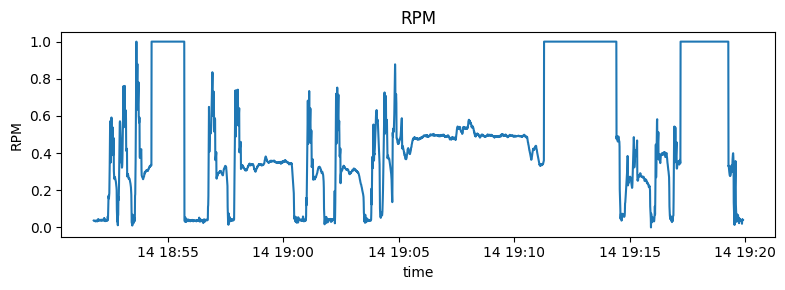

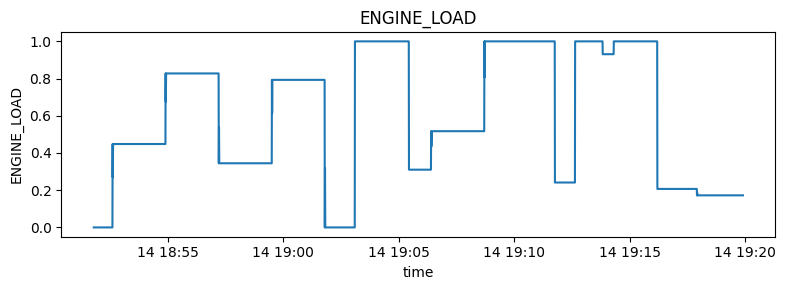

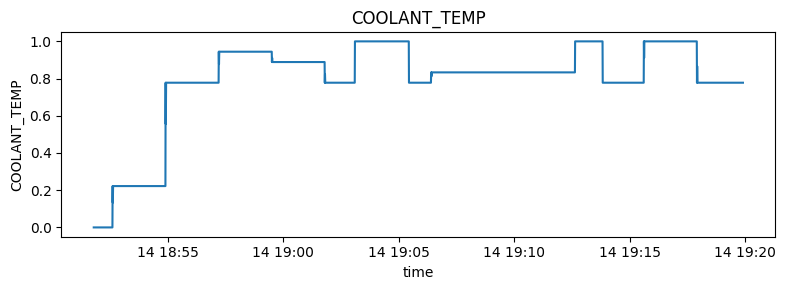

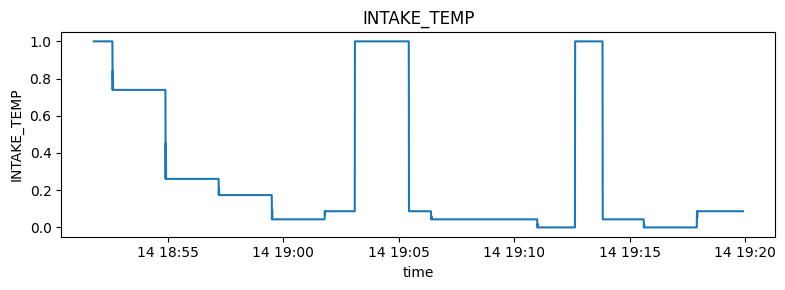

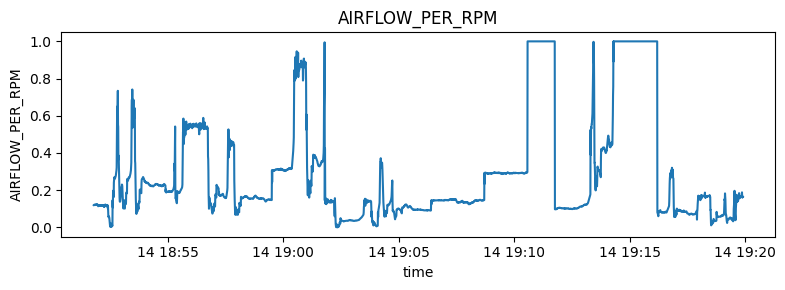

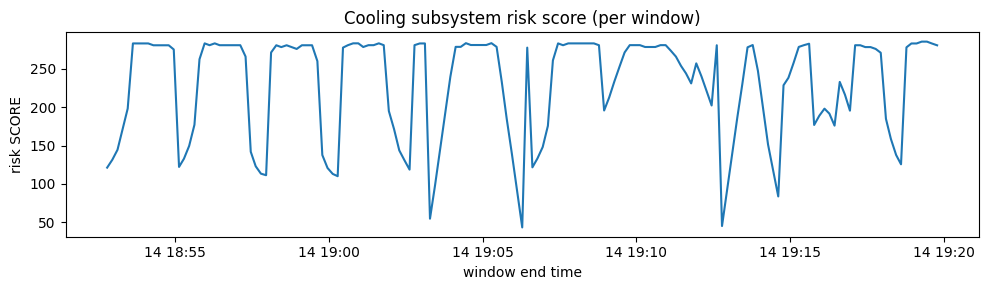

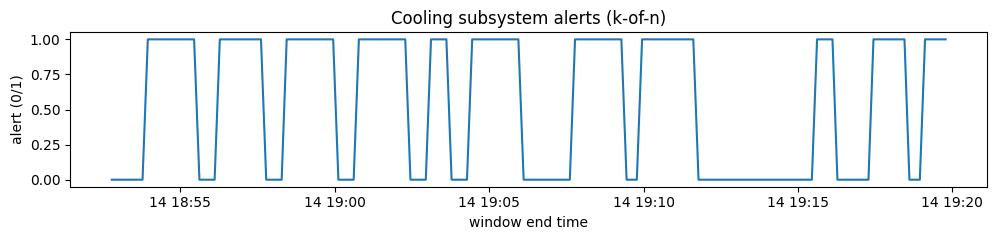

In [114]:
# Cell 13 — Visualizations

def plot_timeseries(frame: pd.DataFrame, col: str):
    if col not in frame.columns:
        print(f"Missing column: {col}")
        return
    plt.figure(figsize=(8, 3))
    plt.plot(frame["timestamp"], frame[col])
    plt.title(col)
    plt.xlabel("time")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

# Sensor plots (pick a few that exist)
for col in ["RPM", "ENGINE_LOAD", "COOLANT_TEMP", "INTAKE_TEMP", "AIRFLOW_PER_RPM"]:
    if col in df.columns:
        plot_timeseries(df.rename(columns={"timestamp":"timestamp"}), col)

# Risk plot (if timeline is non-empty)
if not risk_cooling_alerts.empty:
    plt.figure(figsize=(10, 3))
    plt.plot(risk_cooling_alerts["t1"], risk_cooling_alerts["SCORE"])
    plt.title("Cooling subsystem risk score (per window)")
    plt.xlabel("window end time")
    plt.ylabel("risk SCORE")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 2.5))
    plt.plot(risk_cooling_alerts["t1"], risk_cooling_alerts["alert"])
    plt.title("Cooling subsystem alerts (k-of-n)")
    plt.xlabel("window end time")
    plt.ylabel("alert (0/1)")
    plt.tight_layout()
    plt.show()


## 8) Audit

In [115]:
# Cell 14 — Optional: Persist thresholds & exposure summaries for audit

def summarize_exposure(exposure_by_subsystem: Dict[str, Dict[str, Dict[str, float]]]) -> pd.DataFrame:
    rows = []
    for subsys, sensors in exposure_by_subsystem.items():
        for pid, d in sensors.items():
            rows.append({
                "subsystem": subsys,
                "pid": pid,
                "TOT": d.get("TOT", np.nan),
                "FREQ": d.get("FREQ", np.nan),
                "MAXRUN": d.get("MAXRUN", np.nan),
                "THRESHOLD": d.get("THRESHOLD", np.nan),
            })
    return pd.DataFrame(rows)

exposure_summary_df = summarize_exposure(exposure_by_subsystem)
display(exposure_summary_df.head())

# Save to CSV (adjust path as needed)
out_dir = Path("./outputs")
out_dir.mkdir(parents=True, exist_ok=True)
exposure_summary_path = out_dir / "exposure_summary.csv"
exposure_summary_df.to_csv(exposure_summary_path, index=False)
print(f"Saved exposure summary: {exposure_summary_path.resolve()}")

,subsystem,pid,TOT,FREQ,MAXRUN,THRESHOLD
0,cooling,COOLANT_TEMP,347.31,4,139.74,1.000000
1,cooling,INTAKE_TEMP,260.61,2,139.74,1.000000
2,cooling,ENGINE_LOAD,505.92,5,181.05,1.000000
3,load_air,ENGINE_LOAD,505.92,5,181.05,1.000000
4,load_air,AIRFLOW_PER_RPM,252.45,31,115.77,0.549656


Saved exposure summary: /content/outputs/exposure_summary.csv
